In [1]:
%matplotlib inline

This cell is literally here just to thank Maragret, Henna, Austen and Padma. I discussed various portions of this exam with them and they were a tremendous help in catching bugs, optimizing the code and pointing me to different resources for help. So thanks guys!!!

In [2]:
# I'm not telling you what to import this time - it's an exam! 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time
from scipy.optimize import curve_fit
import numpy as np
from datetime import datetime, timedelta

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

# A503 - Midterm - Aadya Agrawal

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

### Part a

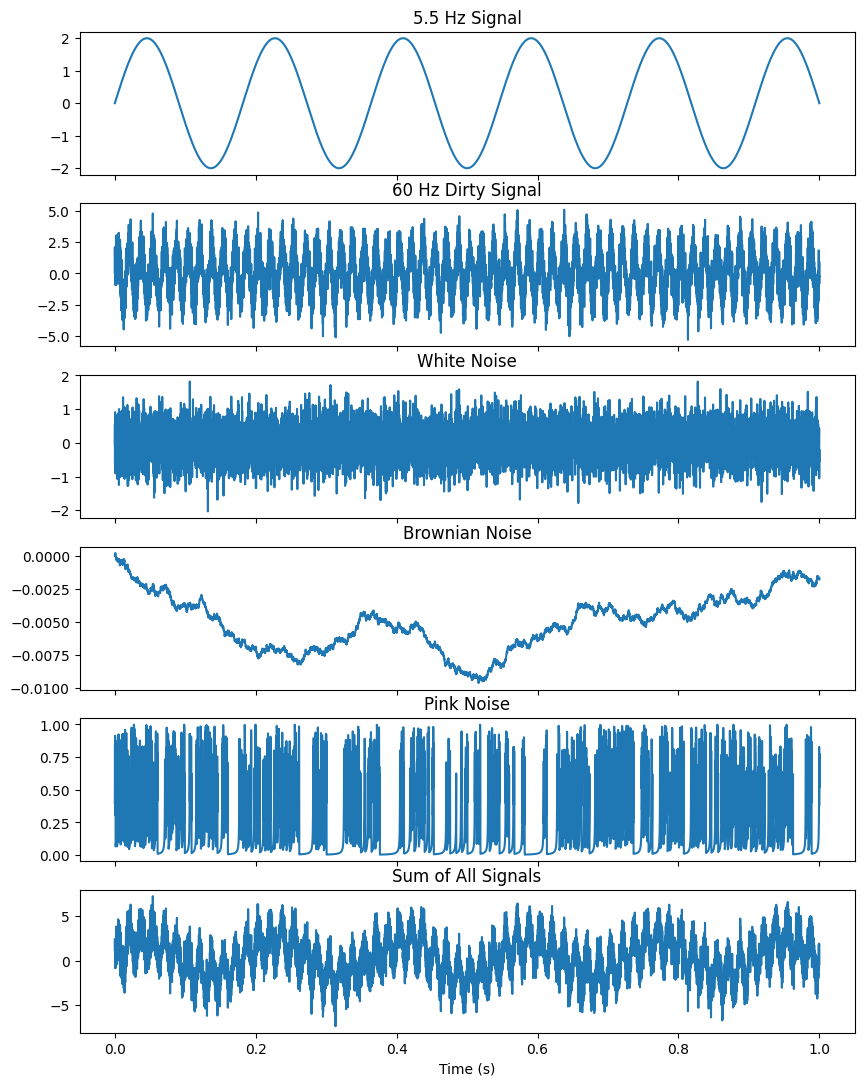

In [3]:
# Q1 a: generate noise and plot them 

# make a 5.5 Hz signal
t = np.linspace(0, 1, 10000) # 1 second, 10 kHz sample rate
fs = 1/(t[1] - t[0])
f = 5.5 
signal = 2*np.sin(2*np.pi*f*t)

# make a 60 Hz dirty signal
f_dirty = 60
dirty_signal_base = 2*np.sin(2*np.pi*f_dirty*t)
dirty_surge = np.random.randn(len(t))          #adding random noise
dirty_signal = dirty_signal_base + dirty_surge

# generate white noise
white_noise = np.random.normal(0, 0.5, len(t)) 

#generate brownian noise using scipy.integrate.simpson to integrate white noise
import scipy.integrate as scint
brownian_noise = np.zeros(len(t))
for i in range(1, len(t)):
    #integrate white noise from 0 to t
    brownian_noise[i] = scint.simpson(white_noise[:i], dx=t[1]-t[0])  #I intially did np.cumsum but was later informed that simpson was better.

#generate pink noise
# x_t = (x_(t-1) + x_(t-1)^2) mod 1
pink_noise = np.zeros(len(t))
pink_noise[0] = np.random.rand()
for i in range(1, len(t)):
    pink_noise[i] = (pink_noise[i-1] + pink_noise[i-1]**2) % 1 

#sum of all the above signals
summed = signal + dirty_signal + white_noise + brownian_noise + pink_noise

#plot each in a subplot with shared x-axis
fig, axs = plt.subplots(6, 1, figsize=(10, 13), sharex=True)
axs[0].plot(t, signal)
axs[0].set_title('5.5 Hz Signal')
axs[1].plot(t, dirty_signal)
axs[1].set_title('60 Hz Dirty Signal')
axs[2].plot(t, white_noise)
axs[2].set_title('White Noise')
axs[3].plot(t, brownian_noise)
axs[3].set_title('Brownian Noise')
axs[4].plot(t, pink_noise)
axs[4].set_title('Pink Noise')
axs[5].plot(t, summed)
axs[5].set_title('Sum of All Signals')
plt.xlabel('Time (s)')
plt.show()

### Part b

In [4]:
#Q1 b: measure the standard deviavtion of each signal and count where the signal goes above 3 standard deviations

#standard deviation of each signal
std_signal = np.std(signal)
std_dirty = np.std(dirty_signal)
std_white = np.std(white_noise)
std_brownian = np.std(brownian_noise)
std_pink = np.std(pink_noise)
std_summed = np.std(summed)

#count where the signal goes above 3 standard deviations
count_signal = np.sum(np.abs(signal) < 3*std_signal)
count_dirty = np.sum(np.abs(dirty_signal) > 3*std_dirty)
count_white = np.sum(np.abs(white_noise) > 3*std_white)
count_brownian = np.sum(np.abs(brownian_noise) < 3*std_brownian)
count_pink = np.sum(np.abs(pink_noise) > 3*std_pink)
count_summed = np.sum(np.abs(summed) > 3*std_summed)

print('Standard deviation of 5.5Hz signal: ', std_signal, ' \nCount of 5.5Hz signal below 3 standard deviations: ', count_signal)
print('Standard deviation of dirty 60Hz signal: ', std_dirty, '\nCount of dirty 60Hz signal above 3 standard deviations: ', count_dirty)
print('Standard deviation of white noise: ', std_white, '\nCount of white noise above 3 standard deviations: ', count_white)
print('Standard deviation of brownian noise: ', std_brownian, '\nCount of brownian noise below 3 standard deviations: ', count_brownian)
print('Standard deviation of pink noise: ', std_pink, '\nCount of pink noise above 3 standard deviations: ', count_pink)
print('Standard deviation of summed signal: ', std_summed, '\nCount of summed signal above 3 standard deviations: ', count_summed)


Standard deviation of 5.5Hz signal:  1.409398759626271  
Count of 5.5Hz signal below 3 standard deviations:  10000
Standard deviation of dirty 60Hz signal:  1.7189125004859496 
Count of dirty 60Hz signal above 3 standard deviations:  1
Standard deviation of white noise:  0.49893292396433153 
Count of white noise above 3 standard deviations:  25
Standard deviation of brownian noise:  0.002075170515919739 
Count of brownian noise below 3 standard deviations:  6856
Standard deviation of pink noise:  0.2665226788279682 
Count of pink noise above 3 standard deviations:  597
Standard deviation of summed signal:  2.2840707223293752 
Count of summed signal above 3 standard deviations:  3


### part c

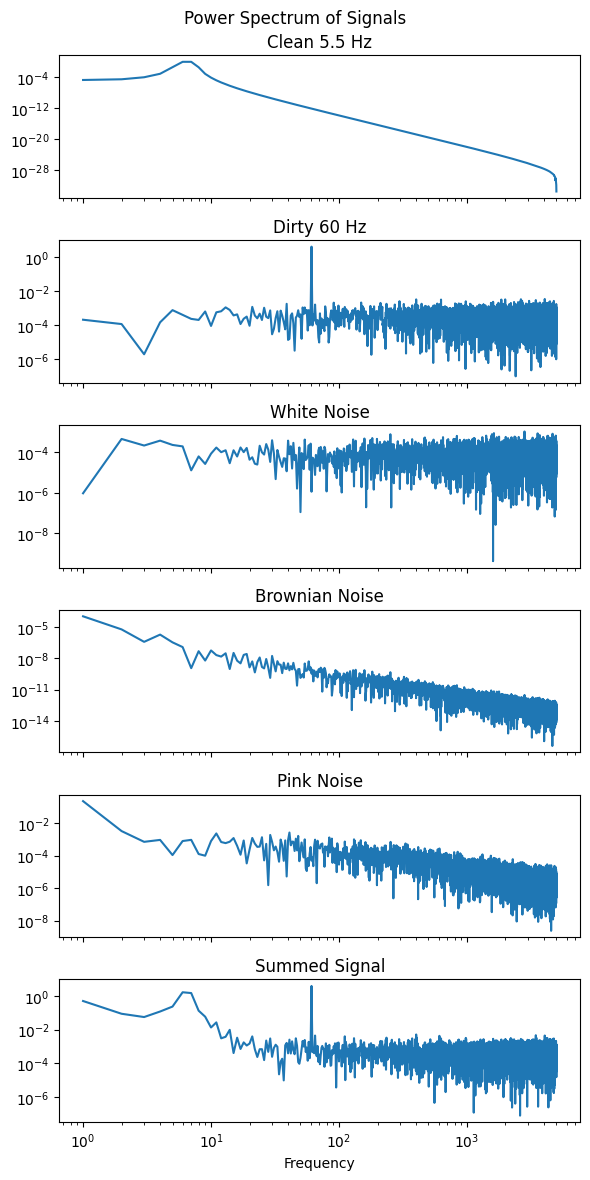

In [5]:
# Q1 c: do fourier transform of the signals and plot the power spectrum for each signal

#defining a positive frequency range
freq = np.fft.fftfreq(len(t), 1/(fs))
freq_pos = freq[np.where(freq > 0)]

#add hannning filter for the 5.5Hz signal
window = np.hanning(len(t))
signal_window = signal*window

#function to get the power spectrum of each signal
def power_spectrum(timestream):
    timestream_fft = np.fft.fft(timestream, n=len(t))
    timestream_pos = timestream_fft[np.where(freq_pos > 0)]
    timestream_pws = np.abs(timestream_pos)**2/(len(timestream_pos)**2)
    return timestream_pws
# dirty_fft = np.abs(np.fft.fft(dirty_signal))
# white_fft = np.abs(np.fft.fft(white_noise))
# brownian_fft = np.abs(np.fft.fft(brownian_noise))
# pink_fft = np.abs(np.fft.fft(pink_noise))
# summed_fft = np.abs(np.fft.fft(summed))
signal_pws = power_spectrum(signal_window)
dirty_pws = power_spectrum(dirty_signal)
white_pws = power_spectrum(white_noise)
brownian_pws = power_spectrum(brownian_noise)
pink_pws = power_spectrum(pink_noise)
summed_pws = power_spectrum(summed)

#plot the power spectrum for each signal
fig, ax = plt.subplots(6, 1, figsize=(6, 12), sharex=True)
ax[0].loglog(freq_pos, signal_pws, label='clean')
ax[0].set_title('Clean 5.5 Hz')
ax[1].loglog(freq_pos, dirty_pws, label='dirty')
ax[1].set_title('Dirty 60 Hz')
ax[2].loglog(freq_pos, white_pws, label='white')
ax[2].set_title('White Noise')
ax[3].loglog(freq_pos,brownian_pws, label='brownian')
ax[3].set_title('Brownian Noise')
ax[4].loglog(freq_pos, pink_pws, label='1/f')
ax[4].set_title('Pink Noise')
ax[5].loglog(freq_pos, summed_pws, label='summed')
ax[5].set_title('Summed Signal')
ax[5].set_xlabel('Frequency')
fig.suptitle('Power Spectrum of Signals')
plt.tight_layout()
plt.show()


### part d

White noise slope:  0.018525798816835103
White noise slope error:  0.018411244175765347


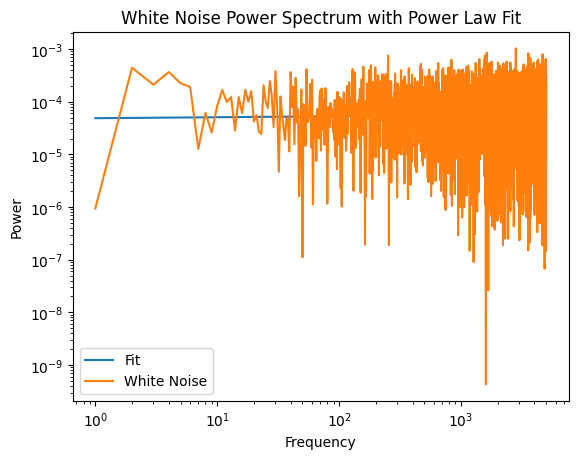

Brownian noise slope:  -1.9545569817166704
Brownian noise slope error:  0.018125576727724496


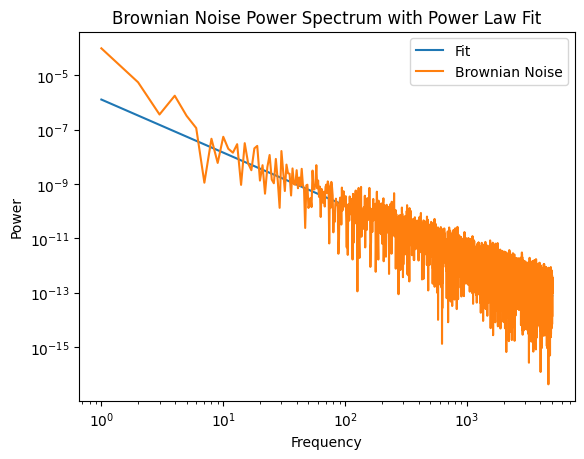

Pink noise slope:  -1.133792095257962
Pink noise slope error:  0.018323464941473622


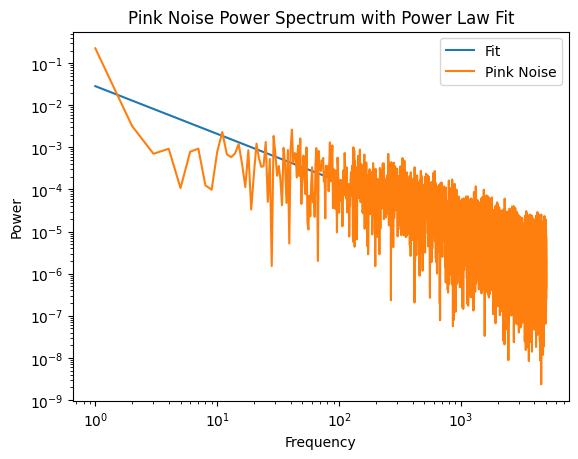

In [6]:
# Convert power law to linear form
def power_law(x, a, b):
    return a * x + b

# Generic function to fit power law and find the slope of noise components
def fit_power_law(noise_pws):
    logx = np.log10(freq_pos)
    logy = np.log10(noise_pws)
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, logx, logy, maxfev=10000)
    slope = popt[0]
    slope_error = np.sqrt(np.diag(pcov))[0]
    return popt, slope, slope_error

# Apply the function to white noise
popt_white, slope_white, slope_error_white = fit_power_law(white_pws)
print('White noise slope: ', slope_white)
print('White noise slope error: ', slope_error_white)

# Plot the fit for white noise
plt.loglog(freq_pos, 10**power_law(np.log10(freq_pos), *popt_white), label='Fit')
plt.loglog(freq_pos, white_pws, label='White Noise')
plt.title('White Noise Power Spectrum with Power Law Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.show()

# Apply the function to brownian noise
popt_brownian, slope_brownian, slope_error_brownian = fit_power_law(brownian_pws)
print('Brownian noise slope: ', slope_brownian)
print('Brownian noise slope error: ', slope_error_brownian)

# Plot the fit for brownian noise
plt.loglog(freq_pos, 10**power_law(np.log10(freq_pos), *popt_brownian), label='Fit')
plt.loglog(freq_pos, brownian_pws, label='Brownian Noise')
plt.title('Brownian Noise Power Spectrum with Power Law Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.show()

# Apply the function to pink noise
popt_pink, slope_pink, slope_error_pink = fit_power_law(pink_pws)
print('Pink noise slope: ', slope_pink)
print('Pink noise slope error: ', slope_error_pink)

# Plot the fit for pink noise
plt.loglog(freq_pos, 10**power_law(np.log10(freq_pos), *popt_pink), label='Fit')
plt.loglog(freq_pos, pink_pws, label='Pink Noise')
plt.title('Pink Noise Power Spectrum with Power Law Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.show()



### part e

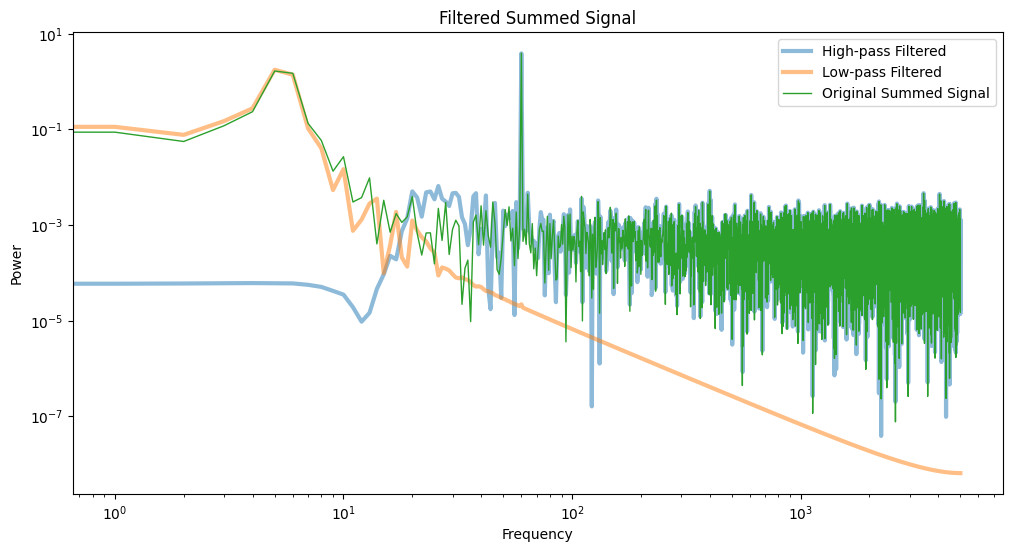

In [7]:
# apply a high-pass filter to the summed signal and plot the power spectrum
from scipy.signal import butter, filtfilt

# use the butterworth filter to get the coefficients for the high-pass filter
def butter_highpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Use coeffs to get the high-pass filter
def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply the high-pass filter to the summed signal
summed_filtered_high = highpass_filter(summed, 20, fs)

#using butterworth again for coeffs
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# repeated here for low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply the low-pass filter
summed_filtered_low = lowpass_filter(summed, 20, fs)

#apply both filters to the summed signal
# summed_filtered_both = lowpass_filter(summed_filtered_high, 10, 100)

# Plot the power spectrum of the filtered signals
summed_filtered_pws_high = power_spectrum(summed_filtered_high)
summed_filtered_pws_low = power_spectrum(summed_filtered_low)
# summed_filtered_fft_both = np.abs(np.fft.fft(summed_filtered_both))

plt.figure(figsize=(12, 6))
plt.plot(summed_filtered_pws_high, label='High-pass Filtered', alpha=0.5, linewidth=3)
plt.plot(summed_filtered_pws_low, label='Low-pass Filtered', alpha=0.5, linewidth=3)
plt.plot(summed_pws, label='Original Summed Signal', linestyle='-', linewidth=1)
# plt.plot(summed_filtered_fft_both, label='Both Filters')
plt.legend()
plt.title('Filtered Summed Signal')
plt.xlabel('Frequency')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Power')
plt.show()


# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [8]:
# load in the fits files

DES_g = fits.open('midterm_data/DESJ053816.9-503050.8_g.fits')
DES_r = fits.open('midterm_data/DESJ053816.9-503050.8_r.fits')
DES_i = fits.open('midterm_data/DESJ053816.9-503050.8_i.fits')
SPT_220 = fits.open('midterm_data/SPT0538-50_SPT_220GHz.fits')
ALMA_870 = fits.open('midterm_data/SPT0538-50_ALMA_870um.fits')

# calculate the std of each image to get the noise level
images = [SPT_220[0].data, ALMA_870[0].data]

std = []
for i in range(2):
    print('Standard deviation of image', i+1, ': ', np.std(images[i]))
    std.append(np.std(images[i]))

#calculate max signal/noise ratio for each image 
def max_snr(image, std):
    return np.max(image)/std

max_snr_values = []
for i in range(2):
    print('Max signal/noise ratio for image', i+1, ': ', max_snr(images[i], std[i]))
    max_snr_values.append(max_snr(images[i], std[i]))

Standard deviation of image 1 :  7.949267e-05
Standard deviation of image 2 :  0.0013849463
Max signal/noise ratio for image 1 :  8.572112
Max signal/noise ratio for image 2 :  18.99373


In [9]:
# GET 3,5,7,9 SIGMA LEVELS
def get_sigma(std, sigma):
    return sigma*std

print("3 sigma level for SPT image: ", get_sigma(std[0], 3))
print("5 sigma level for SPT image: ", get_sigma(std[0], 5))
print("7 sigma level for SPT image: ", get_sigma(std[0], 7))
print("9 sigma level for SPT image: ", get_sigma(std[0], 9))

print("5 sigma level for ALMA image: ", get_sigma(std[1], 5))
print("10 sigma level for ALMA image: ", get_sigma(std[1], 10))
print("15 sigma level for ALMA image: ", get_sigma(std[1], 15))
print("20 sigma level for ALMA image: ", get_sigma(std[1], 20))

3 sigma level for SPT image:  0.00023847801
5 sigma level for SPT image:  0.00039746333
7 sigma level for SPT image:  0.00055644865
9 sigma level for SPT image:  0.000715434
5 sigma level for ALMA image:  0.0069247317
10 sigma level for ALMA image:  0.013849463
15 sigma level for ALMA image:  0.020774195
20 sigma level for ALMA image:  0.027698927


The image below has the SPT and ALMA contours plotted on top of the composite rgb image mage with the gri DES images. The one below that is zoomed into the central regions to show the ALMA contours. 

![Alt text](/Users/amazi/Work/ast503_2024_Fall/homework/aadya29/midterm_data/Final.png)


![Alt text](/Users/amazi/Work/ast503_2024_Fall/homework/aadya29/midterm_data/Closeup_contours.png)


# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [10]:
# Vega coordinates
RA = '18:36:56'
DEC = '+38:47:01'

## Part a: Convert the coordinates to decimal degrees

#Convert RA to decimal degrees
h,m,s = map(float, RA.split(':'))
ra_deg = 15*(h + m/60 + s/3600)

#convert DEC to decimal degrees
sign = -1 if DEC[0] == '-' else 1
d,m,s = map(float, DEC[1:].split(':'))
dec_deg = sign*(d + m/60 + s/3600)
print(ra_deg, dec_deg)

# #check using astropy
# vega = SkyCoord(ra=RA, dec=DEC, unit=(u.hourangle, u.deg))
# print(vega.ra.deg, vega.dec.deg)

279.23333333333335 38.78361111111111


These are the equations for the tranformation from equitorial coordinates (ra, dec) to galactic coordinates (l,b):
$$ \tan{l_0 - l} = \frac{\cos{\delta} \sin{\alpha - \alpha_0}}{\sin{\delta}\cos{\delta_0} - \cos{\delta} \sin{\delta_0}\cos{\alpha-\alpha_0}} $$
and
$$ \sin{b} = \sin{\delta}\sin{\delta_0} + \cos{\delta}\cos{\delta_0}\cos{\alpha - \alpha_0} $$

where the refrence ra, dec and l are from the J2000 epoch

In [11]:
## Part b: Convert the coordinates to Galactic coordinates
#getting ra_2000, dec_2000 and l_2000 for the tranformation
ra_2000 = 192.8595 #degrees
dec_2000 = 27.1284 #degrees
l_2000 = 122.9320 #degrees

#convert to radians because np.sin and np.cos take radians
ra_rad = np.radians(ra_deg)
dec_rad = np.radians(dec_deg)
ra_2000_rad = np.radians(ra_2000)
dec_2000_rad = np.radians(dec_2000)

#calculate the galactic coordinates
numerator = np.cos(dec_rad) * np.sin(ra_rad - ra_2000_rad)
denominator = (np.sin(dec_rad) * np.cos(dec_2000_rad) - 
               np.cos(dec_rad) * np.sin(dec_2000_rad) * np.cos(ra_rad - ra_2000_rad))

l_l_2000 = np.arctan2(numerator,denominator)
l = l_2000 - np.degrees(l_l_2000)
b = np.arcsin(np.sin(dec_rad)*np.sin(dec_2000_rad) + np.cos(dec_rad)*np.cos(dec_2000_rad)*np.cos(ra_rad - ra_2000_rad)) 

# Normalize l to be in [0, 360) degrees
l_deg = l % 360

#convert to degrees
b_deg = np.degrees(b)

print(l_deg, b_deg)
#check using astropy
vega = SkyCoord(ra=RA, dec=DEC, unit=(u.hourangle, u.deg))
print(vega.galactic.l.deg, vega.galactic.b.deg)


67.44776428719481 19.23835342337857
67.44773817064588 19.238253586512474


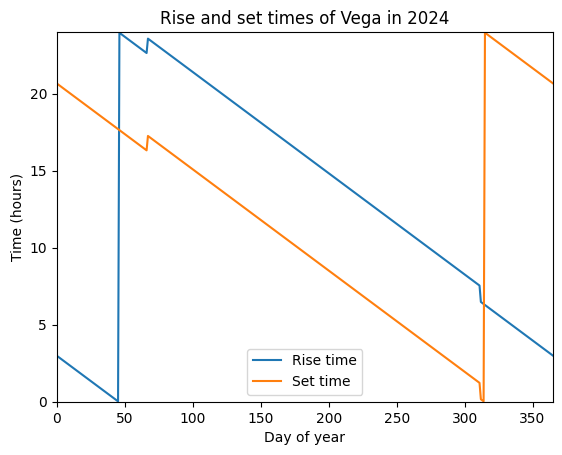

In [12]:
#part c: calculate the rise and set times for Vega at the UIUC Observatory for all days in 2024 (I DID THIS WITHOUT ASTROPY!!!)
#(Ok I used astropy to do it first then redid it without....)

# Convert to julian date
def jd_from_date(date):
    year = date.year
    month = date.month
    day = date.day

    if month <= 2:
        year -= 1
        month += 12

    A = np.floor(year / 100)
    B = 2 - A + np.floor(A / 4)

    jd = np.floor(365.25 * (year + 4716)) + np.floor(30.6001 * (month + 1)) + day + B - 1524.5
    return jd

# convert to regular date
def date_from_jd(jd):
    jd += 0.5
    Z = int(jd)
    F = jd - Z
    if Z < 2299161:
        A = Z
    else:
        alpha = int((Z - 1867216.25) / 36524.25)
        A = Z + 1 + alpha - int(alpha / 4)

    B = A + 1524
    C = int((B - 122.1) / 365.25)
    D = int(365.25 * C)
    E = int((B - D) / 30.6001)

    day = B - D - int(30.6001 * E) + F
    month = E - 1 if E < 14 else E - 13
    year = C - 4716 if month > 2 else C - 4715

    return datetime(year, month, int(day))

#this function calculates the rise and set times for a given ra, dec, and date
def get_rise_and_set_time(ra, dec, date):

    # Coordinates of UIUC Observatory
    lat = 40.112  # degrees
    lon = -88.221  # degrees
    
    # Convert ra and dec to degrees if needed
    ra_deg = ra * 15  # convert RA from hours to degrees
    dec_deg = dec  # already in degrees
    
    # Convert lat, dec, and H to radians for calculation
    lat_rad = np.radians(lat)
    dec_rad = np.radians(dec_deg)
    
    # Calculate the hour angle
    H = np.degrees(np.arccos(-np.tan(lat_rad) * np.tan(dec_rad))) / 15
    
    # Calculate LST at rise and set
    LST_rise = (24 + ra - H) % 24
    LST_set = (ra + H) % 24
    
    # Convert LST to GST
    longitude_hours = lon / 15
    GST_rise = (LST_rise - longitude_hours) % 24
    GST_set = (LST_set - longitude_hours) % 24
    
    # Calculate GMST for the date
    JD = date  # Julian date from J2000
    T = (JD - 2451545.0) / 36525  # Julian centuries since J2000
    
    GMST0 = 6.697374558 + 2400.051336 * T + 0.000025862 * T**2
    GMST0 = GMST0 % 24
    
    # Convert GST to UT
    UT_rise = (GST_rise - GMST0) % 24
    UT_set = (GST_set - GMST0) % 24
    
    # Determine if DST applies
    date = date_from_jd(JD)
    if (date.month > 3 or (date.month == 3 and date.day >= 8)) and (date.month < 11 or (date.month == 11 and date.day <= 7)):
        time_zone_offset = -5  # CDT
    else:
        time_zone_offset = -6  # CST
    
    # Convert UT to local time with DST adjustment
    LT_rise = (UT_rise + time_zone_offset) % 24
    LT_set = (UT_set + time_zone_offset) % 24

    return LT_rise, LT_set

# this function loops over the dates to get times for the year for a given ra and dec
def calculate_rise_set_times_2024(ra, dec):
    """Calculate the rise and set times for all days in 2024 without astropy."""
    start_date = datetime(2024, 1, 1)
    start_jd = jd_from_date(start_date)  # Julian Date of '2024-01-01'
    date_range = np.arange(0, 366, 1)  # Include leap day in 2024

    rise_times = []
    set_times = []

    for i in date_range:
        current_jd = start_jd + i
        
        # Get the rise and set times for the current date
        trise, tset = get_rise_and_set_time(ra, dec, current_jd)
        rise_times.append(trise)
        set_times.append(tset)

    return rise_times, set_times

# Vega coordinates
ra = 18 + (36 / 60) + (56 / 3600)  # in hours
dec = 38 + (47 / 60) + (1 / 3600)  # in degrees

# Call the function for all days in 2024
rise_times, set_times = calculate_rise_set_times_2024(ra, dec)

date_range = np.arange(0, 366, 1)
plt.plot(date_range, rise_times, label='Rise time')
plt.plot(date_range, set_times, label='Set time')
plt.xlabel('Day of year')
plt.ylabel('Time (hours)')
plt.title('Rise and set times of Vega in 2024')
plt.ylim(0, 24)
plt.xlim(0, 365)
plt.legend()
plt.show()


In [13]:
### I did this with astropy first to understand the process and did it without astropy above.


#expression from class slides for rise and set times of a source:
#compute hour angle of source using: H = 1/15 cos^-1(-(tan(lat))(tan(dec)))
#LST_rise = 24 + RA - H
#LST_set = RA + H
#convert LST to GST: GST = LST - longitude
#GMST at 0hUT1 = 6h41m50.54841as + (8640184.812866T + 0.093104T^2 - 6.2*10^-6T^3)s
#where T = JD - 2451545.0
#convert UT to local time : LT = UT + time zone conversion


def get_rise_and_set_time(ra, dec, date):
    #source coordinates
    source = coord.SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))

    #location of UIUC obsrvatory
    uiuc = EarthLocation(lat=40.112*u.deg, lon=-88.221*u.deg, height=230*u.m)

    # Calculate the hour angle for observatory
    lat_rad = uiuc.lat.rad
    dec_rad = source.dec.rad
    H = (1/15) * np.degrees(np.arccos(-np.tan(lat_rad)*np.tan(dec_rad)))
    # print(H)

    # Calculate the LST at rise and set
    LST_rise = (24 + source.ra.hourangle - H) 
    LST_set = (source.ra.hourangle + H)

    # Convert LST to GST
    longitude_hours = uiuc.lon.hour
    GST_rise = (LST_rise - longitude_hours) 
    GST_set = (LST_set - longitude_hours) 
    # print(GST_rise, GST_set)

    #Get JD for 2024-01-01 wrt j2000
    JD = Time(date).jd - Time('2000-01-01').jd
    T = JD / 36525 #converting to julian centuries as described in astronomical alamanc
    
    # Calculate GMST at 0h UT1
    GMST0 = 6.697374558 + 2400.051336*T + 0.000025862*T**2
    GMST0 = GMST0 
    # print(GMST0)
    
    # Convert GST to UT
    UT_rise = (GST_rise - GMST0) 
    UT_set = (GST_set - GMST0) 

    # Convert UT to local time
    LT_rise = (UT_rise - 6) % 24
    LT_set = (UT_set - 6) % 24

    return LT_rise, LT_set

trise, tset = get_rise_and_set_time(vega.ra, vega.dec, '2024-01-01')
print('Rise time: ', trise, 'Set time: ', tset)


Rise time:  2.946929468339931 Set time:  20.627588267468695


### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!